In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 1897835971


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 600,
    "to_freeze_count": 150
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 155,
    'warmup_factor': 5
}
config.update(optuna_result_attachement)
config

{'model_name': 'EleutherAI/gpt-neo-125M',
 'lr': 0.001,
 'warmup_factor': 5,
 'scheduler': 'cosine_schedule_with_warmup',
 'lr_end': 2e-06,
 'power': 0.6,
 'freeze_from_steps': -1,
 'seed': 1897835971,
 'num_epoch': 600,
 'to_freeze_count': 155}

In [5]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Dataset demo snapshot:
<d><scn>bareblur<msg>Wr "That I do."<|endoftext|><d><scn>np1x<msg>Br "There you are, [player_name]."<|endoftext|><d><scn>facin2<msg>Br "You know Anna, right?"<|endoftext|><d><scn>office<msg>Br "Now, please excuse me before I miss happy hour."<|endoftext|><d><scn>facin2<msg>Br "To be frank, I don't know. This is an extraordinary situation, and now that it's getting out of hand, they
 must want to address it."<|endoftext|><d><scn>pad<msg>Br "That whole contest was stupid."<|endoftext|><p><msg>c "I'll keep that in mind, thanks."<|endoftext|><p><msg>c "Okay, my turn."<p><msg>c "What do you think is your biggest physical flaw?"<d><scn>o2<msg>Ad "Well, I wouldn't really call it a flaw, but if I could change one thing, it would probably be these stripes on my muzzle."<d><scn>o2<msg>Ad "I
[0] set freeze_part_layers: True (freezing 155 out of 160 layers.)


Step,Training Loss
636,2.343000
1272,1.818000
1908,1.640200
2544,1.519500
3180,1.428700
3816,1.337100
4452,1.268100
5088,1.217300
5724,1.162300
6360,1.140000


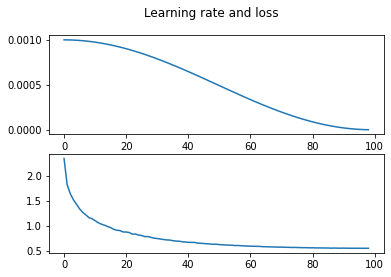

In [6]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [7]:
train_results['model'].eval()
model_manager = ModelManager(model=train_results['model'], tokenizer=train_results['tokenizer'])

In [11]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: <p><msg>c "Hey Remy!"<d><msg>Ry "Hey!"<p><msg>c "How are you?"<d>park2<d><msg>Ry "I'll mess you up if you don't get your face outta my face."<d><msg>c "I'm sorry!"<d><msg>c "I'm sorry!"<d><msg>c "I'm sorry!"<d><msg>c "I'm sorry!"<d><msg>c "I'm sorry!"<d><msg>c "I'm sorry!"<d><


Prompt: What do you think of Lorem?
Reply: <p><msg>c "I was with Lorem today."<d><msg>Ad "Very nice."<p><msg>c "What do you think of Lorem?"<d>Ad "I'm not sure, either."<p><msg>c "I'm not sure, either. It's not a very nice thing for Lorem."<d><msg>c "I'm not sure, either. It's not a very nice thing for Lorem."<d><msg>c "I'm not sure, either. It's not a very nice thing for Lorem."<d


Prompt: Oh my god, Adine. What is this?
Reply: <p><msg>m "In Tatsu park, Adine and I sat down."<p><msg>c "Oh my god, Adine. What is this?"<d>Ad "It's some sort of a recharge, I�� goes out for a few minutes, but it's nowhere again. It's somewhere in the middle of the night."<d><scn>o2<msg>Ad "It's a recha

# Sampling test

Which combination is the best?

In [9]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 13, top_p: 0.9] -> Prompt: How are you?
Reply: Ry "It's<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|>

[Test 1 top_k: 13, top_p: 0.9] -> Prompt: What do you think of Lorem?
Reply: Ad "What are you talking about?"<p><msg>c "You think you can school me?" <p><msg>c "Heh, I canorget?"<d><d><scn>Ad "Heh, you're the one who's supposed to be the one who's supposed to be the one who's supposed to be

In [10]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?


NameError: name 'generate_dragon_reply' is not defined